In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from pytorch_lightning import LightningModule, LightningDataModule, Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
from timm.models.vision_transformer import PatchEmbed, Block
from pytorch_lightning.strategies import DDPStrategy
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture

from models.data import JSRTDataModule, LIDCDataModule

from medmnist.info import INFO
from medmnist.dataset import MedMNIST
from torch.utils.data import DataLoader

from models.mae import ViTAE
from slot_attention import SlotAttention

import matplotlib.pyplot as plt
import matplotlib

In [ ]:
saved_model = ViTAE.load_from_checkpoint('/vol/bitbucket/bc1623/project/semi_supervised_uncertainty/lightning_logs/version_99/checkpoints/epoch=1499-step=4500.ckpt',
    model_kwargs={
        'img_size': 224,
        'embed_dim': 768,
        'num_channels': 1,
        'num_heads': 16,
        'depth': 24,
        'decoder_embed_dim': 768,
        'decoder_depth': 24,
        'decoder_num_heads': 16,
        'norm_layer': nn.LayerNorm,
        'mlp_ratio': 4.0,
        'patch_size': 16,
        'norm_pix_loss': False,
        'dropout': 0.0,
    },
    learning_rate=1e-4,
    map_location=torch.device('cuda:1'),
    )

In [50]:
saved_model.eval()
batch = next(iter(data.train_dataloader()))
with torch.no_grad():
    encoded_embeddings, mask, mask_indices, num_masked_tokens = saved_model.model.encoder(batch['image'].to('cuda:1'), mask_ratio=0.0)

In [64]:
with torch.no_grad():
    decoded_embeddings = saved_model.model.decoder(encoded_embeddings, mask_indices, num_masked_tokens)


Text(0.5, 1.0, 'Difference')

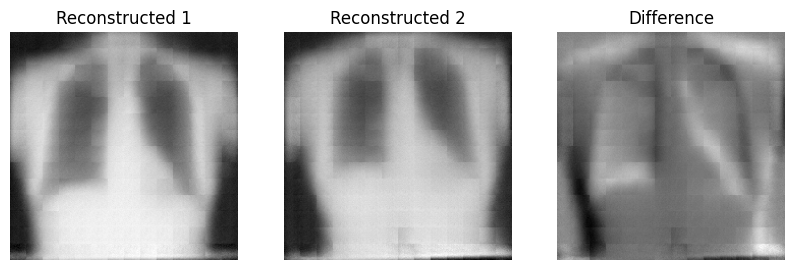

: 

In [76]:
f, ax = plt.subplots(1, 3, figsize=(10, 10))

images = saved_model.model.reverse_patch_sequence(decoded_embeddings)

reconstructed_image1 = images[0, :, :, :].squeeze()
ax[0].imshow(reconstructed_image1.cpu().detach().numpy(), cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('Reconstructed 1')

reconstructed_image2 = images[1, :, :, :].squeeze()
ax[1].imshow(reconstructed_image2.cpu().detach().numpy(), cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('Reconstructed 2')

reconstructed_image3 = reconstructed_image2 - reconstructed_image1

ax[2].imshow(reconstructed_image3.squeeze().cpu().detach().numpy(), cmap=matplotlib.cm.gray)
ax[2].axis('off')
ax[2].set_title('Difference')

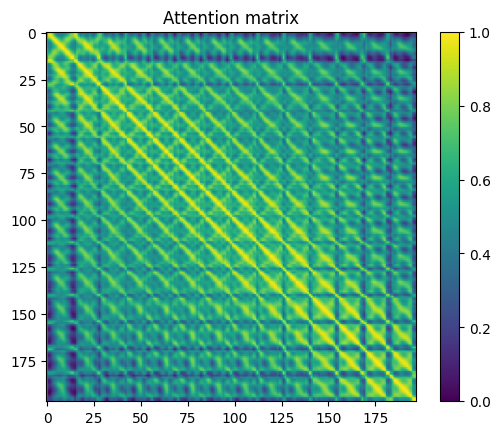

In [53]:
# attention maps
attention = torch.matmul(encoded_embeddings[0, :, :], encoded_embeddings[0, :, :].T)
scaling_factor = encoded_embeddings[0, :, :].shape[1] ** 0.5
attention_matrix = attention / scaling_factor

# normalize attention matrix between  and 1
attention_matrix = (attention_matrix - attention_matrix.min()) / (attention_matrix.max() - attention_matrix.min())

plt.imshow(attention_matrix.cpu().numpy());
plt.title('Attention matrix')
plt.colorbar()
plt.show()


In [54]:
gmm = GaussianMixture(n_components=8, covariance_type='full')
gmm.fit(encoded_embeddings[0, :, :].cpu())

# dpgmm2 = GaussianMixture(n_components=3, covariance_type='full')
# dpgmm2.fit(encoded_embeddings[1, :, :])

GaussianMixture(n_components=8)

Text(0.5, 1.0, 'GMM predictions')

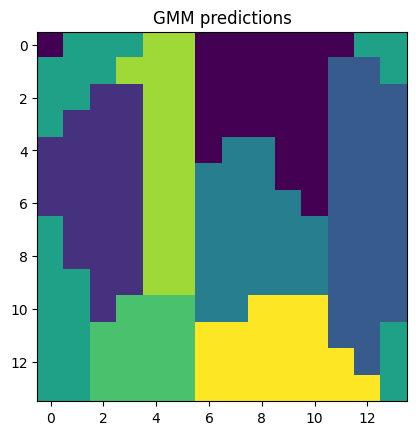

In [56]:
gmm_predictions = gmm.predict(encoded_embeddings[0, :, :].cpu())[:-1].reshape(14, 14)

plt.imshow(gmm_predictions, cmap='viridis');
plt.title('GMM predictions')

Text(0.5, 1.0, 'segmentation')

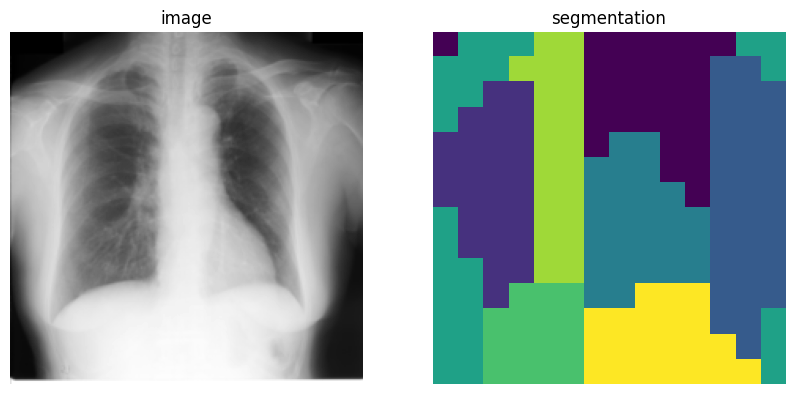

In [62]:
# plot image based on the labels

f, ax = plt.subplots(1, 2, figsize=(10, 10))
image = batch['image'][0].cpu().numpy().squeeze()
ax[0].imshow(image, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('image')

ax[1].imshow(gmm_predictions, cmap='viridis')
ax[1].axis('off')
ax[1].set_title('segmentation')

In [114]:
# sample patch wise feature representations from GMM
image_latent = torch.tensor(dirichlet_mm.sample(197*32)[0], dtype=torch.float32).to('cuda:1').unsqueeze(0)
image_latent = image_latent.reshape(32, 197, 512)

In [115]:
# image_latent = image_latent.permute(2, 0, 1)
# image_latent.shape
num_masked_tokens

0

In [8]:
image_latent = torch.tensor(dpgmm.sample(197*32)[0], dtype=torch.float32).to('cuda:1').unsqueeze(0)
image_latent = image_latent.reshape(32, 197, 512)
image_latent2 = torch.tensor(dpgmm2.sample(197*32)[0], dtype=torch.float32).to('cuda:1').unsqueeze(0)
image_latent2 = image_latent2.reshape(32, 197, 512)
#image_latent = torch.rand(32, 197, 512).to('cuda:1')
with torch.no_grad():
    decoded_image = saved_model.model.decoder(image_latent, mask_indices, num_masked_tokens)
    decoded_image2 = saved_model.model.decoder(image_latent2, mask_indices, num_masked_tokens)

Text(0.5, 1.0, 'Difference')

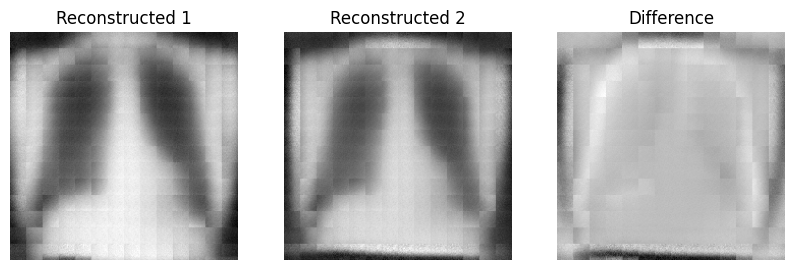

In [9]:
image = decoded_image[0, :, :].unsqueeze(0).cpu()
image2 = decoded_image2[1, :, :].unsqueeze(0).cpu()

# plot image
import matplotlib.pyplot as plt
import matplotlib
#from matplotlib.cm import ScalarMappable

f, ax = plt.subplots(1, 3, figsize=(10, 10))

reconstructed_image1 = saved_model.model.reverse_patch_sequence(image)
ax[0].imshow(reconstructed_image1.squeeze().cpu().detach().numpy(), cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('Reconstructed 1')

reconstructed_image2 = saved_model.model.reverse_patch_sequence(image2)
ax[1].imshow(reconstructed_image2.squeeze().cpu().detach().numpy(), cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('Reconstructed 2')

reconstructed_image3 = reconstructed_image2 - reconstructed_image1

ax[2].imshow(reconstructed_image3.squeeze().cpu().detach().numpy(), cmap=matplotlib.cm.gray)
ax[2].axis('off')
ax[2].set_title('Difference')

In [19]:
decoded_image.shape

(32, 196, 256)

In [18]:
# CNN decoder
from vanilla_unet import Upsample, ConvBlock, EndConvBlock
from torchmetrics.functional import dice
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from pytorch_lightning import LightningModule

class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x):

        # x is from last layer y is skip connection
        x = self.upsample(x)
        x = self.conv(x)

        return x
    
class EndConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EndConvBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return self.conv(x)

class ImageDecoder(LightningModule):
    def __init__(self, output_dim: int, learning_rate: float = 0.001):
        super().__init__()
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.test_probmaps = []
        self.test_predmaps = []

        self.encoder = saved_model.to('cuda:0').model.encoder

        self.up_block_1 = Upsample(256, 128)
        self.up_block_2 = Upsample(128, 64)
        self.up_block_3 = Upsample(64, 16)
        self.conv_block_end = EndConvBlock(16, self.output_dim)


    def forward(self, x):

        with torch.no_grad():
            x, _, _, _ = self.encoder(x, mask_ratio=0.0)

        x = x.permute(2, 1, 0)

        x = self.up_block_1(x)
        x = self.up_block_2(x)
        x = self.up_block_3(x)
        x_out = self.conv_block_end(x)

        return x_out

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def process_batch(self, batch):
        x, y = batch['image'], batch['labelmap']
        logits = self(x)
        loss = F.cross_entropy(logits, y.squeeze())

        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        dsc = dice(preds, y.squeeze(), average='macro', num_classes=self.output_dim, ignore_index=0)

        return loss, dsc, probs, preds

    def training_step(self, batch, batch_idx):
        loss, dsc, probs, preds = self.process_batch(batch)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_dice", dsc, prog_bar=True)

        if batch_idx == 0:
            grid = torchvision.utils.make_grid(batch['image'][0:4, ...], nrow=2, normalize=True)
            self.logger.experiment.add_image('train_images', grid, self.global_step)

            grid = torchvision.utils.make_grid(batch['labelmap'][0:4, ...].type('torch.FloatTensor'), nrow=2, normalize=True)
            self.logger.experiment.add_image('train_labelmaps', grid, self.global_step)

            grid = torchvision.utils.make_grid(probs[0:4, 1:4, ...], nrow=2, normalize=True)
            self.logger.experiment.add_image('train_probmaps', grid, self.global_step)

            grid = torchvision.utils.make_grid(preds[0:4, ...].unsqueeze(1).type('torch.FloatTensor'), nrow=2, normalize=True)
            self.logger.experiment.add_image('train_predmaps', grid, self.global_step)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, dsc, _, _ = self.process_batch(batch)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_dice", dsc, prog_bar=True)

    def on_test_start(self):
        self.test_probmaps = []
        self.test_predmaps = []

    def test_step(self, batch, batch_idx):
        loss, dsc, probs, preds = self.process_batch(batch)
        self.log("test_loss", loss)
        self.log("test_dice", dsc)
        self.test_probmaps.append(probs)
        self.test_predmaps.append(preds)

In [19]:
#seed_everything(42, workers=True)

data = JSRTDataModule(data_dir='./data/JSRT/', batch_size=16)

model = ImageDecoder(output_dim=4, learning_rate=0.001)
#model = ViTSegmenter(output_dim=4, learning_rate=0.001)

trainer = Trainer(
    max_epochs=50,
    precision='16-mixed',
    accelerator='auto',
    devices=[0],
    log_every_n_steps=10,
    logger=TensorBoardLogger(save_dir='./lightning_logs/segmentation/', name='jsrt-conv-unet'),
    callbacks=[ModelCheckpoint(monitor="val_loss", mode='min'), TQDMProgressBar(refresh_rate=10)],
)
trainer.fit(model=model, datamodule=data)

trainer.validate(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

trainer.test(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

True


Loading Data: 100%|██████████| 50/50 [00:00<00:00, 18029.16it/s]
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type         | Params
------------------------------------------------
0 | up_block_1     | Upsample     | 574 K 
1 | up_block_2     | Upsample     | 143 K 
2 | up_block_3     | Upsample     | 19.8 K
3 | conv_block_end | EndConvBlock | 580   
------------------------------------------------
738 K     Trainable params
0         Non-trainable params
738 K     Total params
2.954     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [128, 256, 3, 3], expected input[1, 128, 394, 20] to have 256 channels, but got 128 channels instead